# Imports

In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
import torchvision

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [3]:
cd ../task2

/home/avashchilko/abbyy9sem/course_cvdl/task2


In [4]:
import abbyy_course_cvdl_t2
from abbyy_course_cvdl_t2.convert import PointsToObjects, ObjectsToPoints
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.loss import CenterNetLoss

In [5]:
cd ../task3

/home/avashchilko/abbyy9sem/course_cvdl/task3


In [6]:
device = torch.device('cuda:3')

# Data

In [7]:
base = Path("/home/avashchilko/coco2014")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'train'

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


In [8]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:01.871211
creating index...
index created!


In [9]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [10]:
n_classes = 2
input_shape = (640, 640)

In [11]:
ds_train = CocoTextDetection(
    images_path,
    anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
),
    area_fraction_threshold=1/32/32
)

In [12]:
ds_val = CocoTextDetection(
    images_path,
    anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
    ),
    area_fraction_threshold=1/32/32,
    split='val'
)

In [13]:
x, y = ds_train[6]

In [14]:
y[:10]

tensor([[334.7333, 151.4000,  31.3333,  33.6000,   1.0000,   1.0000],
        [328.8000, 391.9500,  28.8000,  49.7000,   1.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

In [15]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=2, shuffle=True
)

In [16]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

# Learning

In [17]:
net = CenterNet(pretrained="resnet34", head_kwargs={'c_classes': n_classes}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=n_classes, hw=160))#, l_size_lambda=3)

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
net = train(ds_train, net=net, criterion=crit, batch_size=64, epochs=100, device=torch.device(device), lr=1e-3)

epoch 0|0; total loss:161.83790588378906
last losses: [4853.56103515625, 0.26477310061454773, 1.3108103275299072]
epoch 0|30; total loss:204.60964965820312
last losses: [2.3145830631256104, 0.24475567042827606, 0.6803197860717773]
epoch 0|60; total loss:3.23156476020813
last losses: [2.210064649581909, 0.22273510694503784, 0.6083160042762756]
epoch 0|90; total loss:3.238050699234009
last losses: [2.2934176921844482, 0.24273569881916046, 0.4936947226524353]
epoch 0|120; total loss:3.1213154792785645
last losses: [1.8632886409759521, 0.2020266056060791, 0.5667243003845215]
epoch 0|150; total loss:2.926988124847412
last losses: [2.2906250953674316, 0.28083422780036926, 0.7693095803260803]
epoch 0|180; total loss:2.8304758071899414
last losses: [2.002250909805298, 0.26771414279937744, 0.5500873923301697]
epoch 0|210; total loss:2.67372727394104
last losses: [1.5385441780090332, 0.21902404725551605, 0.5728169679641724]
epoch 0|240; total loss:2.5851430892944336
last losses: [1.5418131351470

epoch 7|30; total loss:1.1576694250106812
last losses: [0.7219262719154358, 0.215410053730011, 0.3018593490123749]
epoch 7|60; total loss:1.1949255466461182
last losses: [0.7040989398956299, 0.19829662144184113, 0.2835542559623718]
epoch 7|90; total loss:1.1662942171096802
last losses: [0.7012542486190796, 0.2218666672706604, 0.4033467769622803]
epoch 7|120; total loss:1.2028921842575073
last losses: [0.6996880769729614, 0.22530677914619446, 0.33282074332237244]
epoch 7|150; total loss:1.200188159942627
last losses: [0.5965726971626282, 0.21298788487911224, 0.212968111038208]
epoch 7|180; total loss:1.1653157472610474
last losses: [0.7215181589126587, 0.2016064077615738, 0.29763904213905334]
epoch 7|210; total loss:1.2000137567520142
last losses: [0.6346118450164795, 0.19858594238758087, 0.2518669664859772]
epoch 7|240; total loss:1.1774266958236694
last losses: [0.6144915819168091, 0.21419453620910645, 0.17192158102989197]
epoch 7|270; total loss:1.1835323572158813
last losses: [0.728

epoch 14|30; total loss:0.7136884331703186
last losses: [0.38577935099601746, 0.2108086496591568, 0.1927482932806015]
epoch 14|60; total loss:0.6687885522842407
last losses: [0.3023257553577423, 0.17867323756217957, 0.17274171113967896]
epoch 14|90; total loss:0.7247191667556763
last losses: [0.35536664724349976, 0.18377813696861267, 0.16156962513923645]
epoch 14|120; total loss:0.6829732656478882
last losses: [0.42295652627944946, 0.20198670029640198, 0.18721231818199158]
epoch 14|150; total loss:0.6715118885040283
last losses: [0.36466988921165466, 0.1967049539089203, 0.20410367846488953]
epoch 14|180; total loss:0.7333381772041321
last losses: [0.340745210647583, 0.19950050115585327, 0.14574295282363892]
epoch 14|210; total loss:0.7473358511924744
last losses: [0.35298988223075867, 0.1784840226173401, 0.16569966077804565]
epoch 14|240; total loss:0.7551056146621704
last losses: [0.463181734085083, 0.19838634133338928, 0.21111434698104858]
epoch 14|270; total loss:0.7737725377082825


epoch 21|0; total loss:0.019040025770664215
last losses: [0.23371325433254242, 0.17723225057125092, 0.16025522351264954]
epoch 21|30; total loss:0.5115387439727783
last losses: [0.17027993500232697, 0.18283440172672272, 0.12902158498764038]
epoch 21|60; total loss:0.4982372522354126
last losses: [0.22319760918617249, 0.16486245393753052, 0.13379618525505066]
epoch 21|90; total loss:0.5066488981246948
last losses: [0.2106284350156784, 0.1867920458316803, 0.10699300467967987]
epoch 21|120; total loss:0.513077974319458
last losses: [0.18957191705703735, 0.18763454258441925, 0.16391721367835999]
epoch 21|150; total loss:0.5134608149528503
last losses: [0.19211119413375854, 0.1774449348449707, 0.11199335008859634]
epoch 21|180; total loss:0.518623948097229
last losses: [0.1947803795337677, 0.18494732677936554, 0.1298874020576477]
epoch 21|210; total loss:0.5109031200408936
last losses: [0.1639566272497177, 0.1487048715353012, 0.11243894696235657]
epoch 21|240; total loss:0.5498494505882263


epoch 27|270; total loss:0.4378882050514221
last losses: [0.15418791770935059, 0.14145806431770325, 0.0896051898598671]
epoch 28|0; total loss:0.014668906107544899
last losses: [0.13368788361549377, 0.16718080639839172, 0.13919848203659058]
epoch 28|30; total loss:0.40330907702445984
last losses: [0.09935739636421204, 0.1394553929567337, 0.08705471456050873]
epoch 28|60; total loss:0.4002252221107483
last losses: [0.1200103759765625, 0.1404430866241455, 0.08531402051448822]
epoch 28|90; total loss:0.4091685116291046
last losses: [0.10833937674760818, 0.14797742664813995, 0.1078818291425705]
epoch 28|120; total loss:0.40848833322525024
last losses: [0.09348053485155106, 0.14734679460525513, 0.10475781559944153]
epoch 28|150; total loss:0.39713531732559204
last losses: [0.14181864261627197, 0.1602301001548767, 0.10916218906641006]
epoch 28|180; total loss:0.4205606281757355
last losses: [0.13737623393535614, 0.17940403521060944, 0.10803192108869553]
epoch 28|210; total loss:0.41631770133

epoch 34|240; total loss:0.35977622866630554
last losses: [0.08611912280321121, 0.13510748744010925, 0.09170600771903992]
epoch 34|270; total loss:0.3417133688926697
last losses: [0.08938653767108917, 0.15156592428684235, 0.11129383742809296]
epoch 35|0; total loss:0.010160873644053936
last losses: [0.07723765820264816, 0.14229969680309296, 0.08528885990381241]
epoch 35|30; total loss:0.35461023449897766
last losses: [0.08998947590589523, 0.1587095856666565, 0.12719276547431946]
epoch 35|60; total loss:0.34547221660614014
last losses: [0.07479587197303772, 0.13533690571784973, 0.07924389839172363]
epoch 35|90; total loss:0.3475809097290039
last losses: [0.08603962510824203, 0.1237456277012825, 0.06485798954963684]
epoch 35|120; total loss:0.3460477888584137
last losses: [0.07348562031984329, 0.13948537409305573, 0.11156192421913147]
epoch 35|150; total loss:0.34134358167648315
last losses: [0.06764766573905945, 0.09965568035840988, 0.05229776352643967]
epoch 35|180; total loss:0.332242

epoch 41|180; total loss:0.3080819845199585
last losses: [0.07043956220149994, 0.13086265325546265, 0.14404253661632538]
epoch 41|210; total loss:0.29741302132606506
last losses: [0.09463376551866531, 0.14173150062561035, 0.11100653558969498]
epoch 41|240; total loss:0.3141413629055023
last losses: [0.0769122764468193, 0.17020882666110992, 0.10005120933055878]
epoch 41|270; total loss:0.30185267329216003
last losses: [0.06455130130052567, 0.119381383061409, 0.08937130123376846]
epoch 42|0; total loss:0.011757397092878819
last losses: [0.07599304616451263, 0.1733190417289734, 0.10340980440378189]
epoch 42|30; total loss:0.30269891023635864
last losses: [0.07645681500434875, 0.12256437540054321, 0.05492641031742096]
epoch 42|60; total loss:0.2947579026222229
last losses: [0.05055554583668709, 0.1467040330171585, 0.06031763553619385]
epoch 42|90; total loss:0.301174521446228
last losses: [0.06249523162841797, 0.15853528678417206, 0.09023698419332504]
epoch 42|120; total loss:0.29069921374

epoch 48|120; total loss:0.2632638216018677
last losses: [0.05773162841796875, 0.1309305876493454, 0.08990371227264404]
epoch 48|150; total loss:0.26155415177345276
last losses: [0.057579655200242996, 0.12333356589078903, 0.07565603405237198]
epoch 48|180; total loss:0.27385568618774414
last losses: [0.052052877843379974, 0.11339002102613449, 0.06928430497646332]
epoch 48|210; total loss:0.2656496465206146
last losses: [0.08117320388555527, 0.14864370226860046, 0.10525127500295639]
epoch 48|240; total loss:0.2750391662120819
last losses: [0.08297023177146912, 0.15144002437591553, 0.08050504326820374]
epoch 48|270; total loss:0.26929301023483276
last losses: [0.09400036931037903, 0.12592922151088715, 0.0730942115187645]
epoch 49|0; total loss:0.010082628577947617
last losses: [0.06800507754087448, 0.1499037891626358, 0.08456997573375702]
epoch 49|30; total loss:0.28408634662628174
last losses: [0.09755741059780121, 0.14268197119235992, 0.08229408413171768]
epoch 49|60; total loss:0.2698

epoch 55|60; total loss:0.22521507740020752
last losses: [0.03876546025276184, 0.13113057613372803, 0.06659828126430511]
epoch 55|90; total loss:0.2374078929424286
last losses: [0.05147301405668259, 0.12470602989196777, 0.08339250832796097]
epoch 55|120; total loss:0.23484642803668976
last losses: [0.055219680070877075, 0.10104312002658844, 0.08833551406860352]
epoch 55|150; total loss:0.23666539788246155
last losses: [0.03985396772623062, 0.13626304268836975, 0.08438343554735184]
epoch 55|180; total loss:0.2310507744550705
last losses: [0.04353366792201996, 0.1251828372478485, 0.0760006457567215]
epoch 55|210; total loss:0.24489983916282654
last losses: [0.052828527987003326, 0.12627682089805603, 0.0865420550107956]
epoch 55|240; total loss:0.23813018202781677
last losses: [0.03708229213953018, 0.09988008439540863, 0.05455867201089859]
epoch 55|270; total loss:0.23484691977500916
last losses: [0.048551999032497406, 0.09501702338457108, 0.05185586214065552]
epoch 56|0; total loss:0.007

epoch 62|0; total loss:0.006078183185309172
last losses: [0.025964433327317238, 0.10022987425327301, 0.05615118145942688]
epoch 62|30; total loss:0.20788359642028809
last losses: [0.029207637533545494, 0.10285504907369614, 0.06789746135473251]
epoch 62|60; total loss:0.19927281141281128
last losses: [0.021196398884058, 0.09993986040353775, 0.052745088934898376]
epoch 62|90; total loss:0.20451083779335022
last losses: [0.03312578797340393, 0.1280430257320404, 0.07523144036531448]
epoch 62|120; total loss:0.20139512419700623
last losses: [0.027508120983839035, 0.1100427657365799, 0.07435017824172974]
epoch 62|150; total loss:0.21221518516540527
last losses: [0.026316173374652863, 0.11087408661842346, 0.05597423389554024]
epoch 62|180; total loss:0.20099680125713348
last losses: [0.023547949269413948, 0.09100040793418884, 0.055685631930828094]
epoch 62|210; total loss:0.2216169536113739
last losses: [0.016792431473731995, 0.11280757933855057, 0.07007283717393875]
epoch 62|240; total loss:

epoch 68|240; total loss:0.17647568881511688
last losses: [0.021394113078713417, 0.08676180243492126, 0.06932352483272552]
epoch 68|270; total loss:0.18057245016098022
last losses: [0.021049639210104942, 0.09219269454479218, 0.05463137850165367]
epoch 69|0; total loss:0.005248522851616144
last losses: [0.017782026901841164, 0.08464759588241577, 0.05502605810761452]
epoch 69|30; total loss:0.1837392896413803
last losses: [0.027713024988770485, 0.09321567416191101, 0.05581806227564812]
epoch 69|60; total loss:0.18017983436584473
last losses: [0.018735630437731743, 0.10600012540817261, 0.04654727131128311]
epoch 69|90; total loss:0.18264015018939972
last losses: [0.021276626735925674, 0.0889439731836319, 0.06257718801498413]
epoch 69|120; total loss:0.18075509369373322
last losses: [0.03466920927166939, 0.10071880370378494, 0.07708808779716492]
epoch 69|150; total loss:0.17620491981506348
last losses: [0.024600941687822342, 0.10533548891544342, 0.08331301063299179]
epoch 69|180; total los

epoch 75|180; total loss:0.19013896584510803
last losses: [0.05561961606144905, 0.09390014410018921, 0.05853360891342163]
epoch 75|210; total loss:0.1941096931695938
last losses: [0.03117753192782402, 0.08496171981096268, 0.06041412055492401]
epoch 75|240; total loss:0.18207895755767822
last losses: [0.02062717080116272, 0.10724388808012009, 0.08223511278629303]
epoch 75|270; total loss:0.16609416902065277
last losses: [0.01154963206499815, 0.07810895144939423, 0.0452348068356514]
epoch 76|0; total loss:0.0046500349417328835
last losses: [0.01506413146853447, 0.07716892659664154, 0.04726798087358475]
epoch 76|30; total loss:0.16477608680725098
last losses: [0.01597720757126808, 0.08772788941860199, 0.05071539059281349]
epoch 76|60; total loss:0.16295437514781952
last losses: [0.015335185453295708, 0.07647287100553513, 0.0663822665810585]
epoch 76|90; total loss:0.16497841477394104
last losses: [0.02095978334546089, 0.09303487092256546, 0.053739581257104874]
epoch 76|120; total loss:0.1

epoch 82|120; total loss:0.13840754330158234
last losses: [0.012956429272890091, 0.06408374011516571, 0.03977217897772789]
epoch 82|150; total loss:0.14499233663082123
last losses: [0.010642504319548607, 0.08237050473690033, 0.04780174046754837]
epoch 82|180; total loss:0.14186714589595795
last losses: [0.008964383974671364, 0.07984349131584167, 0.056500643491744995]
epoch 82|210; total loss:0.14316527545452118
last losses: [0.02098059467971325, 0.062067002058029175, 0.04517688974738121]
epoch 82|240; total loss:0.140720933675766
last losses: [0.00885736383497715, 0.07090708613395691, 0.04148866981267929]
epoch 82|270; total loss:0.137631356716156
last losses: [0.010644638910889626, 0.07110828161239624, 0.048289358615875244]
epoch 83|0; total loss:0.004819298163056374
last losses: [0.00863884948194027, 0.07836456596851349, 0.057575520128011703]
epoch 83|30; total loss:0.14198631048202515
last losses: [0.011217289604246616, 0.07419048994779587, 0.060097530484199524]
epoch 83|60; total l

epoch 89|30; total loss:0.14479467272758484
last losses: [0.020939400419592857, 0.06412730365991592, 0.04367351159453392]
epoch 89|60; total loss:0.14981313049793243
last losses: [0.017947901040315628, 0.07200019806623459, 0.051614001393318176]
epoch 89|90; total loss:0.15302541851997375
last losses: [0.030208967626094818, 0.08356567472219467, 0.06438750773668289]
epoch 89|120; total loss:0.14228224754333496
last losses: [0.009547455236315727, 0.0626240149140358, 0.046645961701869965]
epoch 89|150; total loss:0.13937781751155853
last losses: [0.020595349371433258, 0.06467822194099426, 0.05055840313434601]
epoch 89|180; total loss:0.13563013076782227
last losses: [0.00815877877175808, 0.057805705815553665, 0.049283213913440704]
epoch 89|210; total loss:0.14439357817173004
last losses: [0.011787032708525658, 0.06923089176416397, 0.0599096342921257]
epoch 89|240; total loss:0.14606964588165283
last losses: [0.010815613903105259, 0.05626373738050461, 0.05825139582157135]
epoch 89|270; tota

epoch 95|240; total loss:0.1244034543633461
last losses: [0.009237035177648067, 0.06117406487464905, 0.05023954063653946]
epoch 95|270; total loss:0.11607921123504639
last losses: [0.008724203333258629, 0.06298571825027466, 0.05462346225976944]
epoch 96|0; total loss:0.00319191487506032
last losses: [0.007985962554812431, 0.05408995971083641, 0.033681515604257584]
epoch 96|30; total loss:0.12474560737609863
last losses: [0.007081455085426569, 0.05544731020927429, 0.04320699721574783]
epoch 96|60; total loss:0.11798622459173203
last losses: [0.011236061342060566, 0.061143115162849426, 0.04273168742656708]
epoch 96|90; total loss:0.12060375511646271
last losses: [0.0068172854371368885, 0.06778047233819962, 0.06459685415029526]
epoch 96|120; total loss:0.12039193511009216
last losses: [0.0034292335622012615, 0.05282745137810707, 0.04216557741165161]
epoch 96|150; total loss:0.11683154106140137
last losses: [0.003957919776439667, 0.05168639495968819, 0.048052020370960236]
epoch 96|180; tot

In [19]:
torch.save(net, 'centernet_resnet34_640.pth')

# Quality

## Postprocessing and visualization

In [20]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [21]:
net = torch.load('centernet_resnet34_640.pth')

In [22]:
net.to(device)
net.eval()

CenterNet(
  (backbone): ResnetBackbone(
    (downscale): HeadlessPretrainedResnet34Encoder(
      (md): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3)

In [23]:
x, y = ds_train[6]

with torch.no_grad():
    yp_heat = net(x[None].to(device)).cpu()    
    yp = net(x[None].to(device), return_objects=True).cpu()

class 0 heatmap


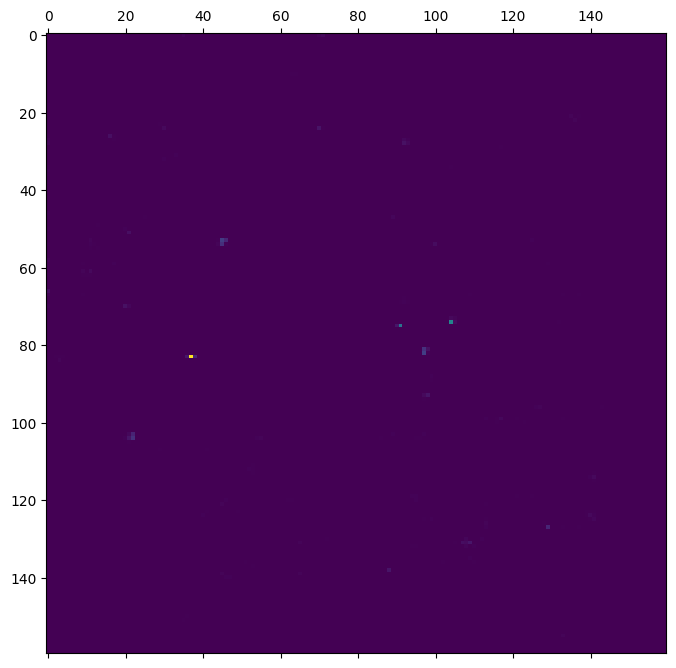

class 1 heatmap


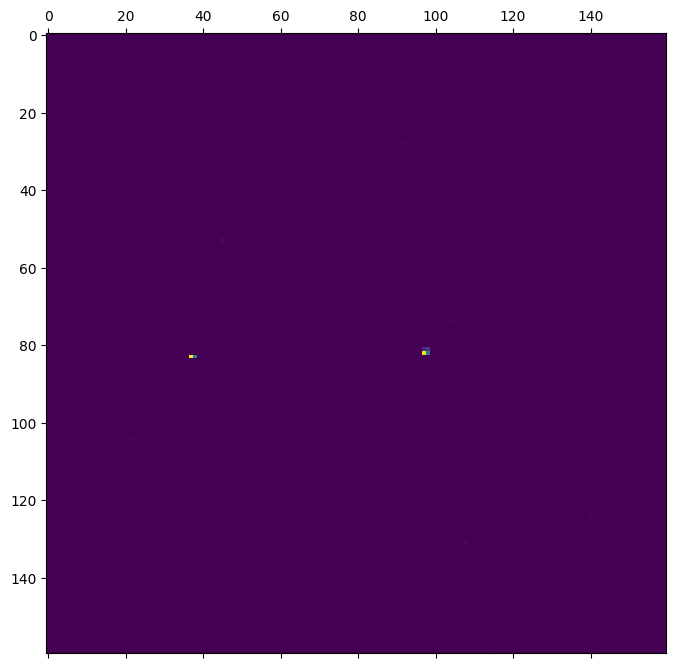

w_heatmap


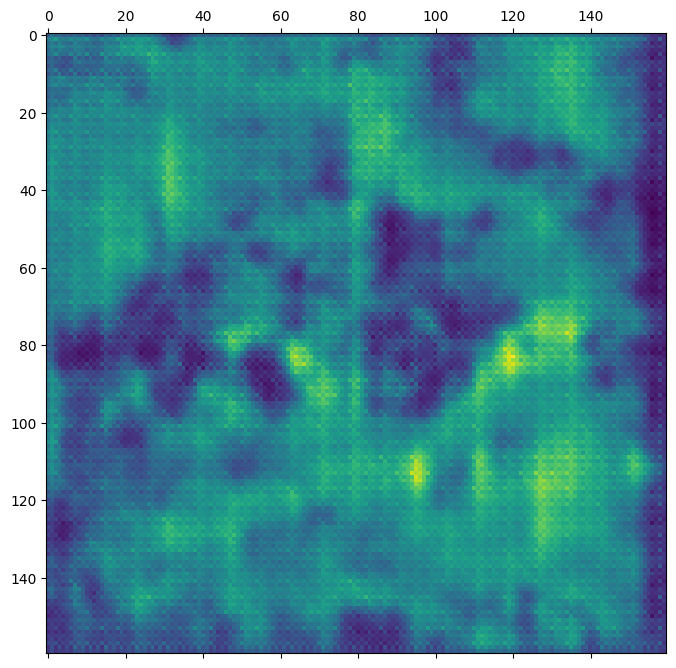

h heatmap


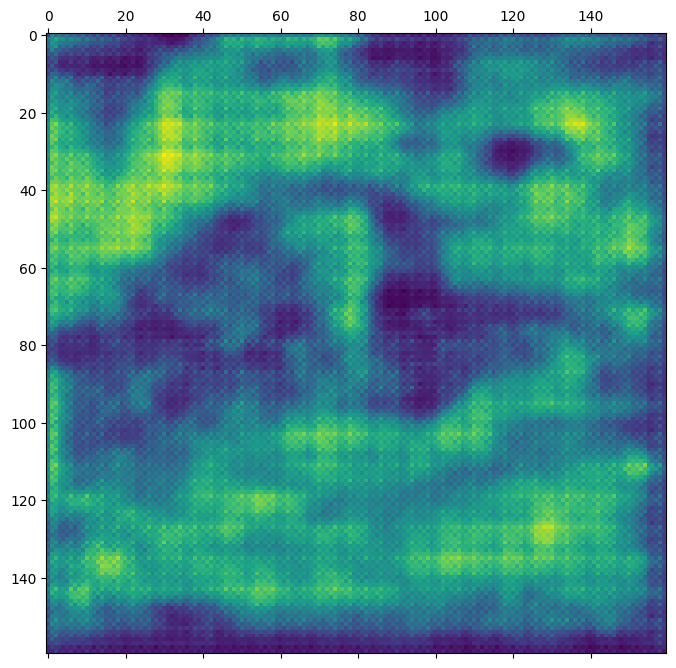

In [24]:
print('class 0 heatmap')
plt.matshow(yp_heat[0][0])
plt.show()

print('class 1 heatmap')
plt.matshow(yp_heat[0][1])
plt.show()

print('w_heatmap')
plt.matshow(yp_heat[0][-1])
plt.show()

print('h heatmap')
plt.matshow(yp_heat[0][-2])
plt.show()

In [25]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]

        hyd2 = torch.div(hy, 2, rounding_mode='trunc')
        wxd2 = torch.div(wx, 2, rounding_mode='trunc')

        img[
                yc - hyd2 - thick : yc - hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val
        img[
                yc + hyd2 - thick : yc + hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val

        img[
                yc - hyd2 : yc + hyd2, 
                (xc - wxd2 - thick): (xc - wxd2 + thick), 
        ] = val
        img[
                yc - hyd2 : yc + hyd2, 
                xc + wxd2 - thick: xc + wxd2 + thick, 
        ] = val
    return img


rnd = lambda x: torch.round(x).long()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


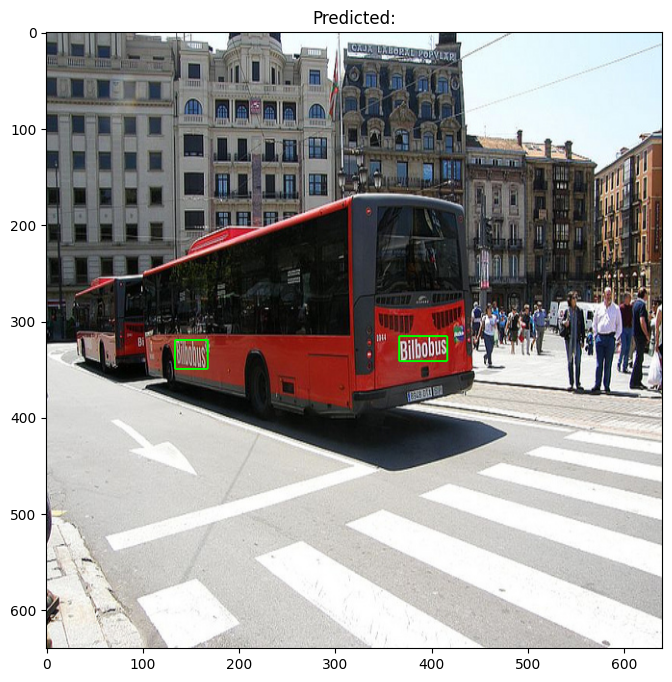

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


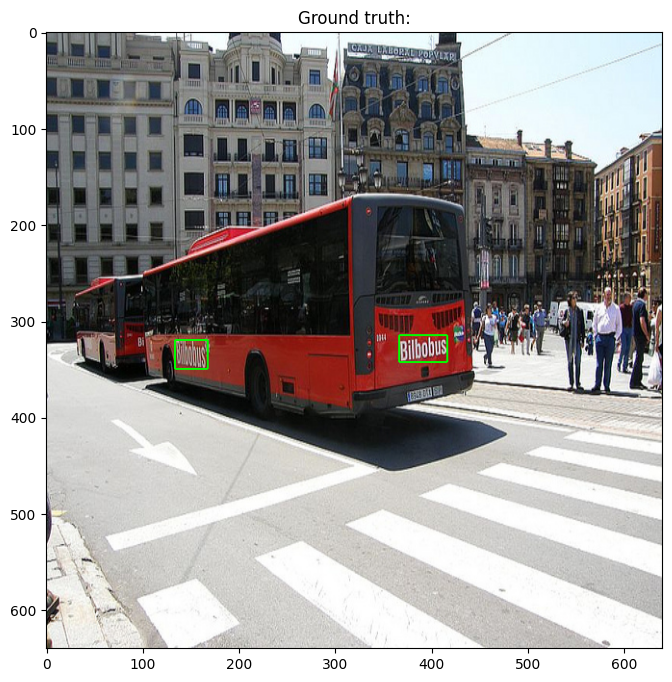

In [26]:
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
))
plt.title('Predicted:')
plt.show()
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
plt.title('Ground truth:')
plt.show()

In [27]:
print(yp[0][:2], y[:2])

tensor([[334.5365, 151.4233,  31.0744,  33.6935,   1.0000,   0.9275],
        [329.1883, 391.6688,  26.4014,  50.3400,   1.0000,   0.9076]]) tensor([[334.7333, 151.4000,  31.3333,  33.6000,   1.0000,   1.0000],
        [328.8000, 391.9500,  28.8000,  49.7000,   1.0000,   1.0000]])


## Saving to json

In [28]:
#net = torch.load('centernet_resnet34_640.pth')

In [29]:
def postprocess(data, target_shape, input_shape):
    unf = {}
    res = data[data[:, -1] != 0]
    boxes = res[:, :4].copy()
    b = boxes.copy()
    result_boxes = np.zeros_like(boxes)
    result_boxes[:, 0] = (boxes[:, 1] - b[:, 3] / 2) * (target_shape[1] / input_shape[1])
    result_boxes[:, 1] = (boxes[:, 0] - b[:, 2] / 2) * (target_shape[0] / input_shape[0])
    result_boxes[:, 2] = boxes[:, 3] * (target_shape[1] / input_shape[1])
    result_boxes[:, 3] = boxes[:, 2] * (target_shape[0] / input_shape[0])
    unf['boxes'] = result_boxes
    unf['scores'] = res[:, -1]
    return unf


def extract_results():
    prepared_preds = []
    img_ids = []

    net.eval()

    for num, img_id in enumerate(tqdm(ds_val.ids)):
        img_id = int(img_id)
        img_meta = ct.loadImgs(ids=[img_id])[0]

        with torch.no_grad():
            x = ds_val[num][0]
            
            pred = net(
                x[None, ...].to(device),
                return_objects=True
            )[0].detach().cpu().numpy()
            prepared_preds.append(
                postprocess(pred, target_shape=(img_meta['height'], img_meta['width']), input_shape=input_shape)
            )
            img_ids.append(img_id)

    scores = np.concatenate([u['scores'] for u in prepared_preds], axis=0)
    boxes = np.concatenate([u['boxes'] for u in prepared_preds], axis=0)
    
    image_ids = []
    
    for num, i in enumerate(img_ids):
        image_ids += [i] * len(prepared_preds[num]['boxes'])
    image_ids = np.array(image_ids)

    dump_detections_to_cocotext_json(
        image_ids = image_ids.tolist(),
        xlefts=boxes[:, 0].tolist(),
        ytops=boxes[:, 1].tolist(),
        widths=boxes[:, 2].tolist(),
        heights=boxes[:, 3].tolist(),
        scores=scores.tolist(),
        path=f'predictions.json'
    )
    
    ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path=f'predictions.json'
    )
    return (ap, prec, rec, len(scores))

# Best AP

100%|████████████████████████████████████████████████████████████████████| 4446/4446 [01:30<00:00, 48.86it/s]


Loading and preparing results...     
DONE (t=0.33s)
Итоговый скор AP на val: 0.3730886187212715


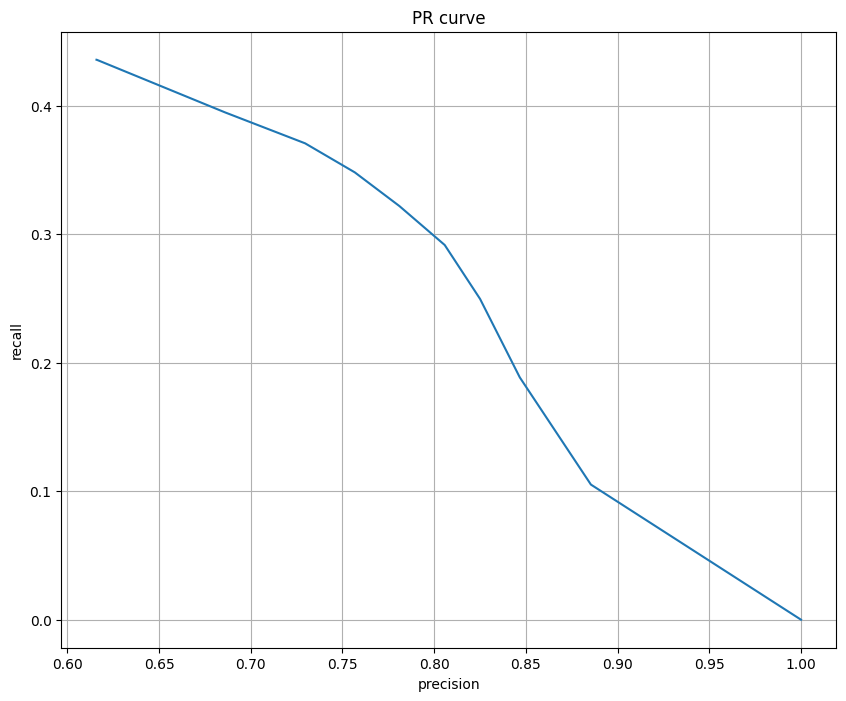

In [30]:
ap, prec, rec, n_obj = extract_results()

print(f"Итоговый скор AP на val: {ap}")

plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.grid()

In [ ]:
n_obj

In [ ]:
rec